# Explore dataset of learning histories

In this notebook we can review the trajectories in the dataset which were collected on the stage 1 of the algorithm distillation and will be used in stage 2 to train the language model.

In [1]:
cd ..

/home/cinemere/work/repo/ad-icrl


/home/cinemere/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
pwd

'/home/cinemere/work/repo/ad-icrl'

In [9]:
# imports:

import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

from src.collect_data.generate_goals import max_episode_reward

In [46]:
# select folder with learning histories & fill variables

pwd_path = os.getcwd()  # path to the repository

LEARNING_HISTORY_DIRS = [  # folders with data
    "saved_data/learning_history/ppo-01",
    "saved_data/learning_history/ppo-02",
    "saved_data/learning_history/ppo-03"]


dir_paths = [os.path.join(pwd_path, _dir) for _dir in LEARNING_HISTORY_DIRS]

episode_length = 20  # length of the episode in data
size = 9  # size of grid in data

# select the directory
selected_dir = 0  # 0, 1 or 3


In [47]:
# reading the directory

files = sorted(os.listdir(dir_paths[selected_dir]))

rewards = []
for index, file in enumerate(files):
    arr = np.load(os.path.join(dir_path, file))
    assert f"goal={index:02}" in file
    rewards.append(arr['rewards'] / max_episode_reward(index))
    # break

rewards = np.stack(rewards, axis=0)
num_goals, num_steps, num_workers = rewards.shape

rewards = rewards.reshape(num_goals, -1, episode_length, num_workers)
episode_rewards = rewards.sum(axis=-2).transpose(0, 2, 1)  # [goals, actors, episode]

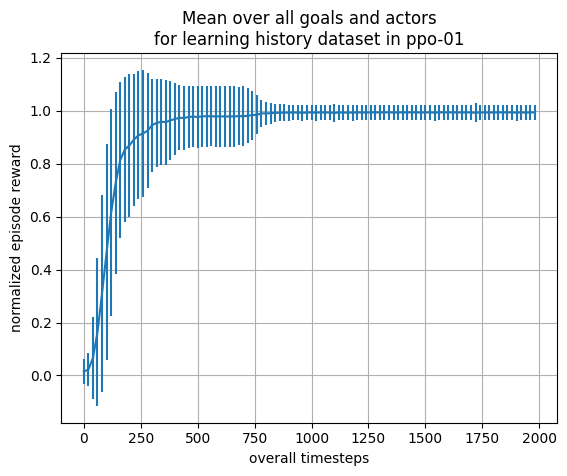

In [51]:
# Plot mean over all goals and actors

mean_ep_rew = episode_rewards.reshape(num_goals * num_workers, -1)

plt.errorbar(
    np.arange(mean_ep_rew.shape[1])  * episode_length, 
    mean_ep_rew.mean(0),
    mean_ep_rew.std(0))
plt.grid()
learning_history_dir = os.path.dirname(dir_path).split(os.sep)[-1]
plt.title("Mean over all goals and actors\n"\
    f"for learning history dataset in {learning_history_dir}")

plt.xlabel("overall timesteps")
plt.ylabel("normalized episode reward")
plt.show()


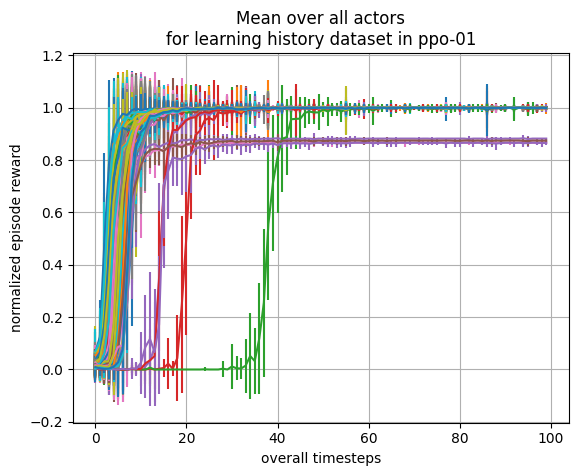

In [49]:
# Plot mean over all actors for each goal

mean_ep_rew_goals = episode_rewards.mean(axis=1)
std_ep_rew_goals  = episode_rewards.std(axis=1)

for i in range(num_goals):
    plt.errorbar(
        np.arange(mean_ep_rew_goals.shape[-1]), 
        mean_ep_rew_goals[i], 
        std_ep_rew_goals[i]
    )
plt.grid()
learning_history_dir = os.path.dirname(dir_path).split(os.sep)[-1]
plt.title("Mean over all actors\n"\
    f"for learning history dataset in {learning_history_dir}")

plt.xlabel("overall timesteps")
plt.ylabel("normalized episode reward")
plt.show()


In [50]:
# Which goals are not trained to oracle?
# Such goals will be manually omited from training dataset.

from src.collect_data.generate_goals import get_all_goals
for goal_index in range(num_goals):
    mean_episode_reward = episode_rewards.mean(axis=1)[goal_index, -1]
    if mean_episode_reward > 0.99:
        continue
    goal = get_all_goals()[goal_index].tolist()
    print(f"{goal_index=:02d} {goal=} {mean_episode_reward=:.4f}")


goal_index=04 goal=[0, 4] mean_episode_reward=0.8824
goal_index=06 goal=[0, 6] mean_episode_reward=0.8667
goal_index=74 goal=[8, 2] mean_episode_reward=0.8660
goal_index=75 goal=[8, 3] mean_episode_reward=0.8744
